<center><img src="./images/nup_logo_dark.jpeg" width="300" style="display: inline-block;"></center>

<h2>ML with Python</h2>
<h3>Introduction to Bayesian Methods</h3>

<br />
<br />
<p>December 19, 2023</p>


<h3>Reminder: Bayes' Theorem</h3>

$$P(A | B) = \frac{P(B | A) P(A)}{\int P(B | A) P(A) dA} = \frac{P(B | A) P(A)}{P(B)}$$

<p>
    In machine learning, this translates as:
</p>

$$P(\theta | Y) = \frac{P(Y | \theta) P(\theta)}{\int P(Y | \theta) P(\theta)},$$

<p>
    where $P(Y | \theta)$ is the likelihood of the data given the model parameters, $P(\theta)$ is the prior distribution of parameters, 
    $P(Y) = \int P(Y | \theta) P(\theta)$ is the marginal likelihood of the data.
</p>

<p>
    General scheme of applying the Bayesian approach:
</p>
<ol>
    <li>Specify the model (that is, set the likelihood function)</li>
    <li>Indicate the prior distribution of parameters. This is the complex part. Generally, the prior distribution should be sufficiently non-informative but at the same time reflect some <em>a priori</em> knowledge about the parameters. There is an entire <a href="https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations">document</a> with "recipes" for choosing a prior distribution</li>
    <li>Apply Bayes' theorem :)</li>
</ol>

<p>
    In practice, computing the posterior distribution is almost always impossible.
    Various kinds of approximations or Markov Chain Monte Carlo methods come to the rescue.
</p>


### Conjugate Distributions. Example

If the posterior distribution $p(\theta | Y)$ for the likelihood function $p(y | \theta)$ is from the same family of distributions 
as the prior $p(\theta)$, such a prior is called conjugate (conjugate) to the likelihood $p(y | \theta)$. 
Such distributions are convenient to work with because in this case the posterior distribution is calculated analytically.

Some conjugate distributions for example.

| Likelihood | Prior | 
|------------|-------|
| (Multivariate) Gaussian   | (Multivariate) Gaussian | 
| Bernoulli | Beta |
| Poisson | Gamma |
| Gaussian | Gamma |


Let's consider the simplest example with a biased coin. Suppose the coin lands on heads with probability $\theta$ 
(in the case of $\theta = 0.5$ the coin is fair). 
The outcomes of the coin tosses follow the distribution $P(\text{coin} = \text{head} | \theta) = \text{Bernoulli}(\theta)$. 
This will be our likelihood function.

How can we estimate the parameter $\theta$ from the data?

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.datasets
from scipy.special import expit
from sklearn.linear_model import LogisticRegression

SEED = 1234
np.random.seed(SEED)  # for reproducibility

In [2]:
# generate some data
theta = 0.7
coin_flips = scipy.stats.bernoulli.rvs(theta, size=10)  # let's use small data

<BarContainer object of 2 artists>

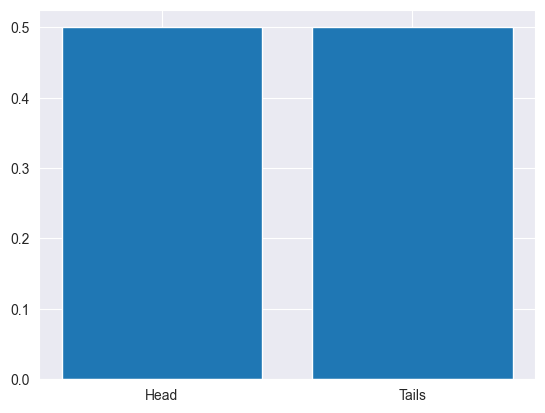

In [3]:
names = ['Head', 'Tails']
data = coin_flips.mean(), 1 - coin_flips.mean()
plt.bar(names, data)

The simplest (frequentist) option is to obtain the maximum likelihood:

In [4]:
theta_mle = coin_flips.mean()
print('MLE for \\theta =', theta_mle)

MLE for \theta = 0.5


**Task.** What happened? Prove that the MLE (Maximum Likelihood Estimation) for $\theta$ is the sample mean.

For the Bernoulli likelihood, the conjugate prior distribution will be the Beta distribution $Beta(\alpha, \beta)$.

The posterior distribution will be $Beta(\alpha + \sum x_i, \beta + n - \sum x_i)$.

We have no basis to assume anything specific about $\alpha$ and $\beta$, so let's choose $\alpha=\beta=1$. 
This distribution coincides with the uniform distribution — we consider that $\theta$ can be anywhere in the interval $[0, 1]$.


In [5]:
a_prior = 1.
b_prior = 1.
beta_prior = scipy.stats.beta(a=a_prior, b=b_prior)
beta_posterior = scipy.stats.beta(a = a_prior + coin_flips.sum(), 
                                  b = b_prior + len(coin_flips) - coin_flips.sum())

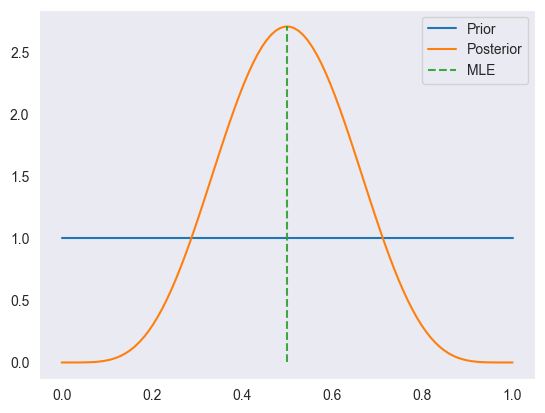

In [6]:
# let's plot a little
x_ = np.linspace(0, 1, 100)

plt.plot(x_, beta_prior.pdf(x_), label='Prior')
plt.plot(x_, beta_posterior.pdf(x_), label='Posterior')
plt.plot([theta_mle, theta_mle], [0, beta_posterior.pdf(theta_mle)], linestyle='--', alpha=0.9, label='MLE')
plt.grid()
plt.legend()

Let's see what happens with a larger amount of data.

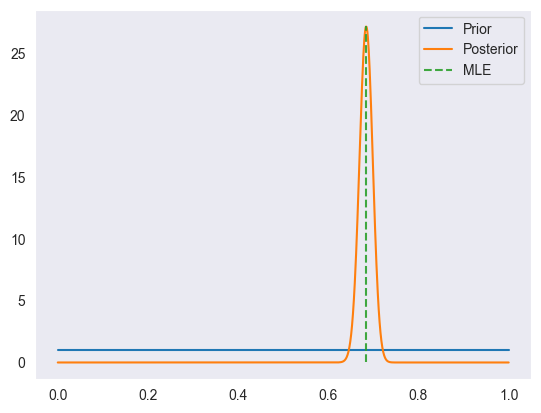

In [7]:
coin_flips = scipy.stats.bernoulli.rvs(theta, size=1000)  # let's use big data (ok, not so big)
beta_posterior = scipy.stats.beta(a = 1. + coin_flips.sum(), b = 1. + len(coin_flips) - coin_flips.sum())
theta_mle = coin_flips.mean()

x_ = np.linspace(0, 1, 1000)
plt.plot(x_, beta_prior.pdf(x_), label='Prior')
plt.plot(x_, beta_posterior.pdf(x_), label='Posterior')
plt.plot([theta_mle, theta_mle], [0, beta_posterior.pdf(theta_mle)], linestyle='--', alpha=0.9, label='MLE')
plt.grid()
plt.legend()

**Task**. Try changing the parameters of the prior distribution to others. 
What will happen in this case with the MLE (Maximum Likelihood Estimation) estimate? What will happen as the amount of data increases?

This example is too simple. First, our parameter space is one-dimensional. 
Second, we are "lucky" that there is a conjugate distribution for the likelihood function.

In the multidimensional case (usually), there is no such luxury.

### Logistic Regression

Logistic regression models the probability that the classified object will be in the positive class:

$$ p(y_i | \theta) = \text{Bernoulli}(p_i) $$
$$ p_i = p(y_i = 1| \theta) = \sigma(\theta_1 x_{i1} + \theta_2 x_{i2} + \ldots + \theta_m x_{im} )$$

This is our likelihood function.

(Reminder: $\sigma(t) = 1 / (1 + \exp(-t))$)

For a dataset $Y = [y_1, \ldots, y_N]^\top$ we will assume conditional independence:

$$
    P(Y | \theta) = \prod_{i=1}^{N} p(y_i | \theta)
$$

For such a likelihood function, there is no conjugate distribution :( 
Therefore, we will have to apply other methods to find the posterior.

In [8]:
# load some data
raw_data = sklearn.datasets.load_breast_cancer()
X = raw_data['data'][:, [0, 4]]
feature_names = raw_data['feature_names'][[0, 4]]
Y = raw_data['target']
target_names = raw_data['target_names']

# normalize the data
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_std = np.where(np.isclose(X_std, 0), 1., X_std)
X_normed = (X - X_mean) / X_std

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_normed, Y)

print('Predicting breast cancer based on %s' % ', '.join(feature_names))

Predicting breast cancer based on mean radius, mean smoothness


Let's look at the dataset:

In [9]:
def plot_classes(X, Y, feature_names, target_names, title):
    colors = ['red', 'green']
    for i, cancer_type in enumerate(target_names):
        where = np.where(Y == i)
        plt.scatter(X[where, 0], X[where, 1], c=colors[i], label=cancer_type)

    plt.title(title)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend(loc='best')

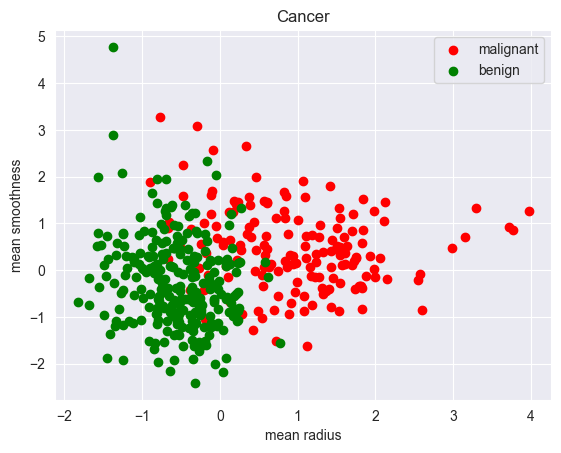

In [10]:
plot_classes(X_train, Y_train, feature_names, target_names, title='Cancer')

Let's choose a prior distribution for our parameters $\theta$. 
For simplicity, let's take a normal distribution with a large variance:

In [11]:
theta_prior = scipy.stats.multivariate_normal(mean = np.zeros(2), cov=10*np.eye(2))

In [12]:
def log_likelihood(theta): 
    dot_product = theta.dot(X_train.T)
    sign = -np.sign(Y_train - 0.5)  # -1 if Y==1, +1 if Y==0
    
    log_likelihood_ = -np.log(1.0 + np.exp(sign * dot_product)).sum(axis=-1)    
    return log_likelihood_

The unnormalized posterior distribution:
    $$ p(\theta | Y) \propto p(Y | \theta) p(\theta) $$

It is more convenient to use the logarithm:
    $$ \log p(\theta | Y) = \log p(Y | \theta) + \log p(\theta) + C $$

In [13]:
def log_unnormed_posterior(theta):
    return log_likelihood(theta) + theta_prior.logpdf(theta)

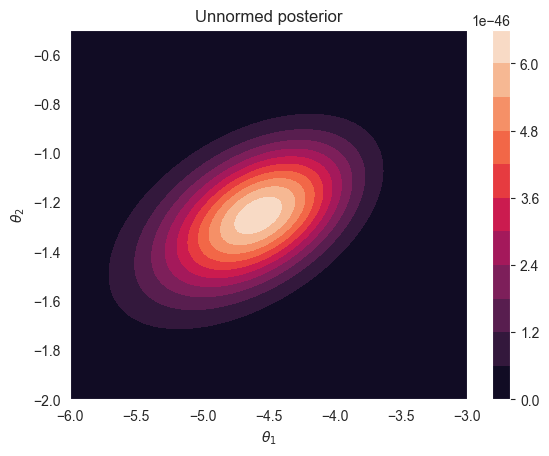

In [15]:
theta_1, theta_2 = np.meshgrid(np.linspace(-6., -3., 100), np.linspace(-2, -.5, 100))  # (100, 100)
theta = np.dstack((theta_1, theta_2))  # (100, 100, 2)

plt.contourf(theta_1, theta_2, np.exp(log_unnormed_posterior(theta)), levels=10)
plt.colorbar()

plt.title('Unnormed posterior')
plt.xlabel('$\\theta_1$')
plt.ylabel('$\\theta_2$');

### MCMC

Let's recall the scheme of the Metropolis-Hastings algorithm.

0. Choose an arbitrary point $x_0$ and a symmetric distribution $Q(x_{n+1} | x_n)$ (proposal rule).

On each iteration:
1. Generate a point $x_{n+1}$ from the distribution $Q(x_{n+1} | x_n)$.
2. Calculate the acceptance ratio
    $$ \alpha = \frac{p(x_{n+1})}{p(x_n)} $$
3. Generate a random $u \sim U[0, 1]$.
4. Accept the new sample if $u \leq \alpha$

In [16]:
x_0 = np.zeros(2)  # why not?
x_current = x_0

n_accepts = 0
n_iter = 10000

metropolis_samples = []

for _ in range(n_iter):
    pass # write your code here

    # solution:
    x_new = np.random.normal(loc = x_current, scale=1e-1)  # standard choice is normal distribution
    acceptance_ratio = np.exp(log_unnormed_posterior(x_new)) / np.exp(log_unnormed_posterior(x_current))
    
    u = np.random.uniform()
    if u < acceptance_ratio:
        x_current = x_new
        metropolis_samples.append(x_new)
        n_accepts += 1
    else:
        metropolis_samples.append(x_current)

In [16]:
print('Efficiency: %.2f' % (n_accepts / n_iter))

Efficiency: 0.79


As a rule, the first, initial samples obtained when the Markov chain has not yet converged to the stationary distribution are discarded. 
This period is called the "burn-in" or "warm-up" phase. 
In addition, adjacent samples tend to be correlated, so they are usually "thinned" by taking not all samples, but only every $N$-th one.

For simplicity, we will set some relatively reasonable values for warm-up and thinning.

In [17]:
burn_in = 1000
sample_sparsifier = 5

theta_samples = np.array(metropolis_samples[burn_in:][::sample_sparsifier])

In [20]:
# sns.jointplot(x=theta_samples[:,0], y=theta_samples[:,1], kind='kde');

We have approximated the posterior distribution quite well. 
It can be seen that the posterior distribution of the parameters is quite wide — in the case of a "point" estimate, this information is lost.

### Predictive Distribution

Ok, but how do we predict the class for _new_ patients?

Let's look at the posterior distribution for $y_*$:
$$p(y_* | Y) = \frac{p(y_*, Y)}{p(Y)} = \int \frac{p(y_*, Y, \theta)}{p(Y)} d\theta = 
\int \frac{p(y_* | Y, \theta) p(Y, \theta)}{p(Y)} d\theta = 
\int p(y_* | Y, \theta) p(\theta | Y) d\theta = \int p(y_* | \theta) p(\theta | Y) d\theta$$

In the last equality, we used the conditional independence of outcomes.

This can be interpreted as: we _average_ the predictions $p(y_* | \theta)$ 
over _all_ possible models $\theta$, weighting them as likely as they are given the available data.

As usual, this integral is not computable :) We can use the Monte Carlo method:
1. Sample $\theta_i$ from the distribution $p(\theta | Y)$
2. Sample $y_*$ from the distribution $p(y_* | \theta_i)$

Thus, we obtain samples from the distribution $p(y_* | Y)$

Let's look at test dataset:

In [21]:
def predict(X):
    prob = expit(theta_samples.dot(X.T))  # logistic function
    
    rv = scipy.stats.bernoulli.rvs(prob)  # samples from predictive distribution
    
    means = np.mean(rv, axis=0)
    variances = np.var(rv, axis=0)
    
    return means, variances

In [23]:
# means, variances = predict(X_test)

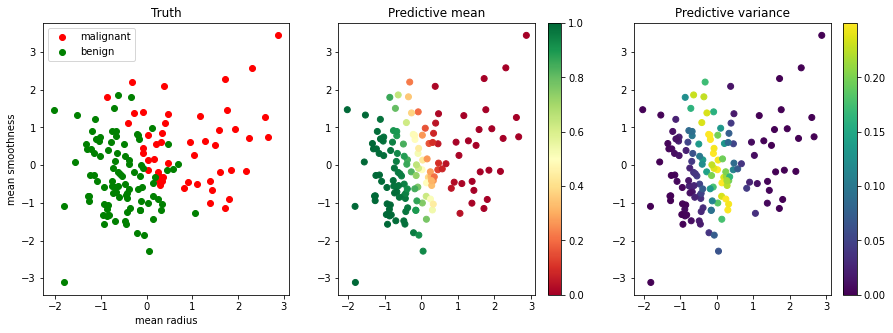

In [36]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plot_classes(X_test, Y_test, feature_names, target_names, title='Truth')

plt.subplot(132)
plt.scatter(X_test[..., 0], X_test[..., 1], c=means, cmap='RdYlGn')
plt.title("Predictive mean")
plt.colorbar()

plt.subplot(133)
plt.scatter(X_test[..., 0], X_test[..., 1], c=variances, cmap='viridis')
plt.title("Predictive variance")
plt.colorbar()

As we can see, at the boundaries of the classes, the average of our predictions is close to 0.5, 
and the variance is higher than within the depths of the classes. This demonstrates the uncertainty of the model — indeed, 
the classes are intermixed, and it is difficult to make a confident prediction at the boundary within the framework of our model.

### Frameworks

We wrote a lot of boilerplate code, but for Python, there are several frameworks for Bayesian inference that make life easier.

* **PyMC3**
    A library based on `theano` (an effectively dead framework). Nonetheless, it has good documentation, many examples, and tutorials. Also, basic visualization.

* **Bambi**
    A layer on top of PyMC3 for simplifying the implementation of Generalized Linear Models.

* **Pyro**
    A library based on `pytorch`.

* **TensorFlow Probability**
    A module for `tensorflow`. 

Let's try to derive the posterior distributions for the parameters of logistic regression for _all_ features. We'll use `pyro`.

In [37]:
import torch
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc

In [38]:
from pyro.infer import Predictive

Data preparation:

In [39]:
X = raw_data['data']
feature_names = raw_data['feature_names']
Y = raw_data['target']
target_names = raw_data['target_names']

# normalize the data
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_std = np.where(np.isclose(X_std, 0.), 1., X_std)
X_normed = (X - X_mean) / X_std

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_normed, Y)

# convert to torch
X_train, X_test, Y_train, Y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), \
    torch.tensor(Y_train).float(), torch.tensor(Y_test).float()

n_features = X.shape[-1]

Let's set up a logistic regression model. As prior distributions, we'll again use "wide" Gaussians.

In [40]:
burn_in = 1000
n_samples = 9000

def logistic_regression(x, y):
    intercept = pyro.sample("intercept", dist.Normal(torch.tensor([0.0]), torch.tensor([10.0])))
    theta = pyro.sample("theta", dist.Normal(torch.zeros(n_features), 10.0*torch.ones(n_features)))
    
    linear = intercept + torch.matmul(theta, x)
    
    obs = pyro.sample("obs", dist.Bernoulli(logits = linear), obs=y)
    
    return obs

We'll use a more "advanced" MCMC method called NUTS (No U-Turn Sampler).

NUTS utilizes gradients to explore the posterior distribution more efficiently. 
(That is, the proposal rule is more complex than just a Gaussian).

We won't delve into the details of NUTS, as it goes beyond the scope of this course.

**Warning:** The following cell may take a long time to execute.

In [41]:
kernel = mcmc.NUTS(logistic_regression, jit_compile=False)

posterior = mcmc.MCMC(kernel,
                      num_samples=n_samples,
                      warmup_steps=burn_in,
                      num_chains=1,
                      disable_progbar=False)

posterior.run(X_train.T, Y_train)

Sample: 100%|█████████████████████████████████████| 10000/10000 [39:17,  4.24it/s, step size=2.94e-02, acc. prob=0.908]


We will obtain samples from the posterior distribution.

In [43]:
samples = posterior.get_samples()

In [45]:
samples['theta'] = samples['theta'][::sample_sparsifier]
samples['intercept'] = samples['intercept'][::sample_sparsifier]

Let's look at the marginal distributions of the samples.

In [46]:
theta_samples = samples['theta'].numpy()

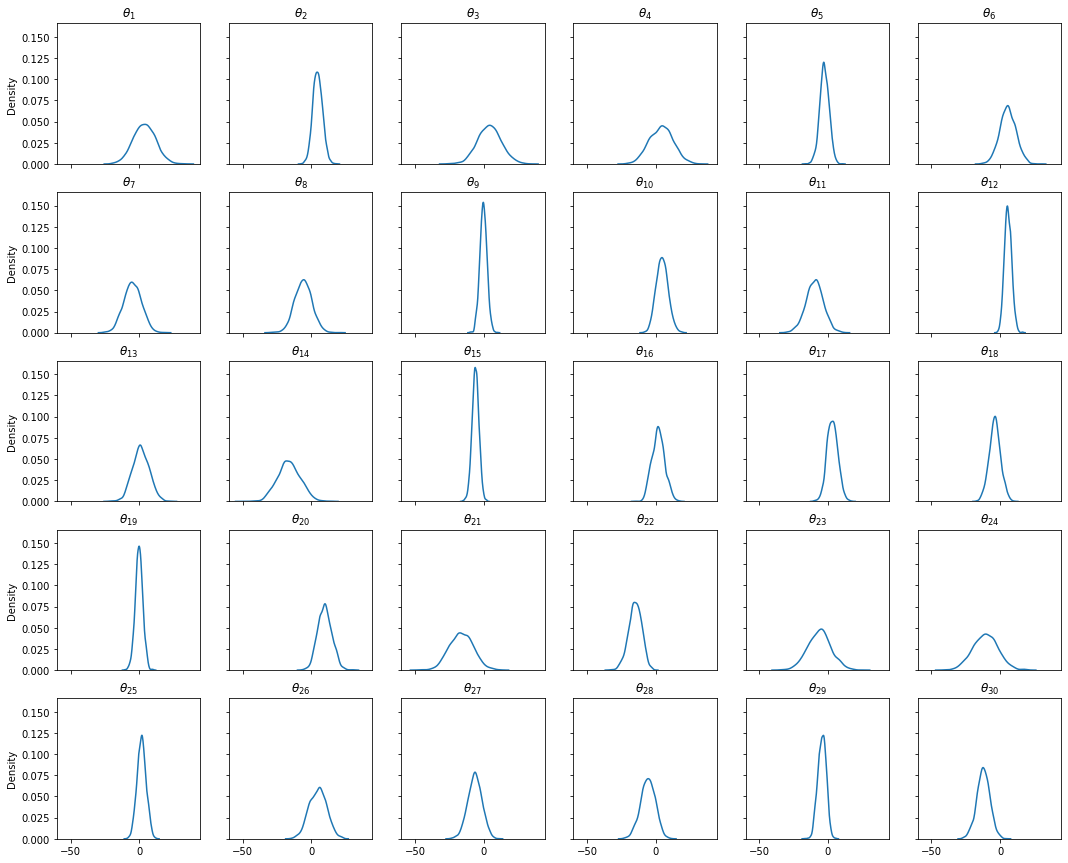

In [47]:
n_rows = 5
n_cols = 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 15), sharey=True, sharex=True)

for i in range(theta_samples.shape[-1]):
    
    ax = plt.subplot(n_rows, n_cols, i+1)
    sns.kdeplot(ax=ax, x=theta_samples[:, i])
    ax.set_title('$\\theta_{%d}$' % (i+1))

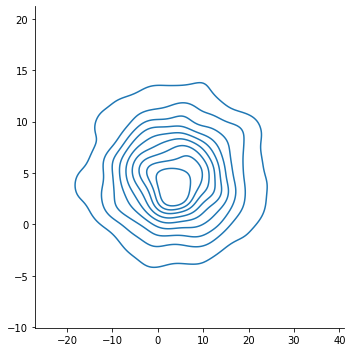

In [48]:
sns.displot(x=theta_samples[:, 0], y=theta_samples[:, 1], kind='kde')

**Question**: What can be said about the distributions of the parameters? 
Which parameters have been estimated confidently, and in which is there a high degree of uncertainty?

Let's try to predict something.

In [49]:
predictive = Predictive(logistic_regression, samples)(X_test.T, None)

In [50]:
means = predictive['obs'].mean(axis=0)
variance = predictive['obs'].var(axis=0)

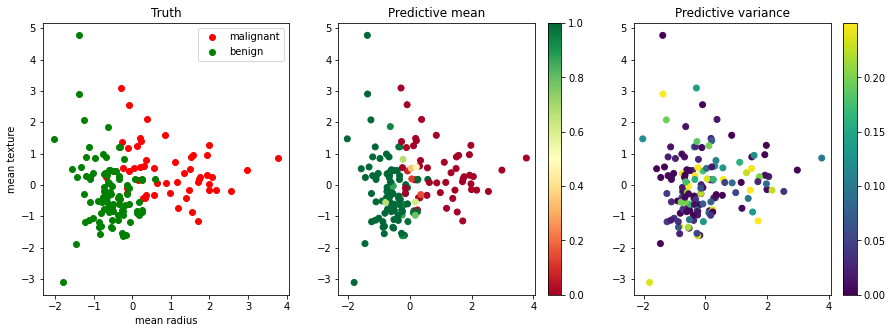

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plot_classes(X_test[:, [0, 4]], Y_test, feature_names, target_names, title='Truth')

plt.subplot(132)
plt.scatter(X_test[:, 0], X_test[:, 4], c=means, cmap='RdYlGn')
plt.title("Predictive mean")
plt.colorbar()

plt.subplot(133)
plt.scatter(X_test[:, 0], X_test[:, 4], c=variances, cmap='viridis')
plt.title("Predictive variance")
plt.colorbar()

### Materials

Interactive visualization of various MCMC algorithms: [https://chi-feng.github.io/mcmc-demo/](https://chi-feng.github.io/mcmc-demo/)

Conceptual introduction to MCMC: [https://arxiv.org/abs/1909.12313](https://arxiv.org/abs/1909.12313)

### This is Not All

The Bayesian view accounts for the uncertainty inherent in machine learning tasks. 
Bayesian models don't provide fixed answers but rather a distribution of answers.

MCMC is one method for obtaining the posterior distribution. Its main drawback is high computational complexity. 
Besides, there are other ways to obtain (approximately) posterior distributions (such as variational inference).

Furthermore, as you may recall, there's a "special" likelihood, the Multivariate Gaussian, for which the conjugate prior is the Multivariate Gaussian. 
This leads to another powerful Bayesian model of Gaussian processes. But that is a separate story for the next semester :)

### Thank you for your attention!